<IPython.core.display.Javascript object>


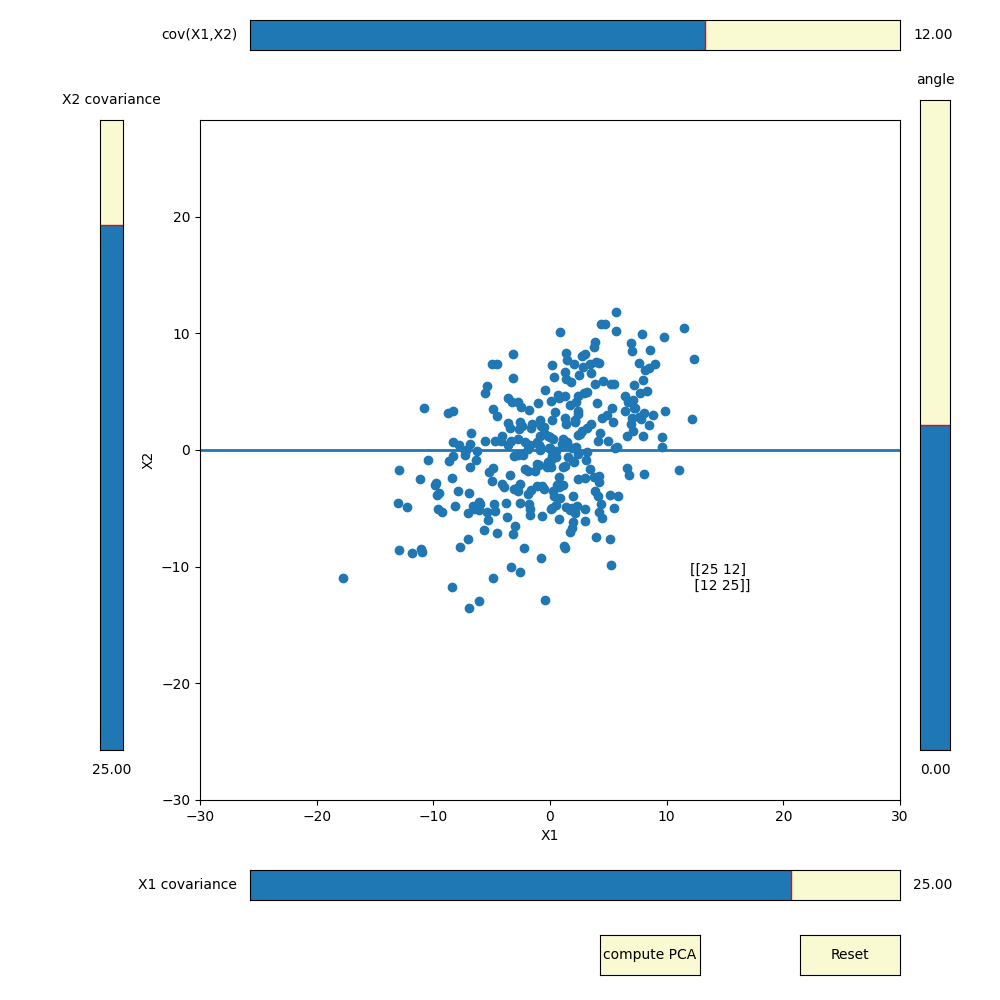

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from ipywidgets import interact
%matplotlib notebook

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd



def f(sigma_1, sigma_2, sigma_cross, n_samples=300):
    ### f(sigma_1, sigma_2, sigma_cross, n_samples=300)
    ### sigma_1 : cov(X1, X1), sigma_2 : cov(X2, X2), sigma_cross=cov(X1, X2)=cov(X2, X1), n_samples: number of samples to draw
    #### a bivariate gaussian distribution sampling function

    # number of dimensions
    d = 2
    # covoriance matrix
    K = np.array([[sigma_1, sigma_cross], \
                  [sigma_cross, sigma_2]])
    # zero mean (=> simpler for the "game" to find the projection angle bellow)
    mu = np.array([0.0, 0.0])
    # sampling from a bivariate (d=2) gaussian distribution
    # by applying the lower-triangular matrix L to make x follow the distribution implied by the covariance matrix
    L = np.linalg.cholesky(K + 1e-6*np.eye(d))
    u = np.random.normal(size=(d, n_samples))
    x = np.dot(L, u)
    # unused because of zero mean
    # x[0, :] = mu[0] + x[0, :]
    # x[1, :] = mu[1] + x[1, :]

    return x, K



# The projection function to plot the projected points on the principal direction
def project_method2(data, angle):
    a = np.tan(angle  * np.pi / 180) # the line has equation y = a * x
    e = np.array([[1, a]]) # vector e is along the principal direction
    data_p = (np.dot(data.T, e.T)/np.dot(e, e.T))*e # projection by scalar product amplitude along direction of vector e.
    return data_p.T

def get_line(t, angle):
    a = np.tan(angle  * np.pi / 180)
    y = a * t
    return y

# Define initial parameters
init_X1_cov = 25
init_X2_cov = 25
init_cross_cov = 12
init_angle = 0

# Create the figure
fig, ax = plt.subplots(figsize=(10,10))
plt.xlim(-20,20)
plt.ylim(-20,20)
# create and scatter bivariate gaussian distributed data (also retrieve the covariance matrix)
data, K = f(init_X1_cov, init_X2_cov, init_cross_cov)
sc = ax.scatter(data[0, :], data[1, :])
# display the covariance matrix on the figure
t1 = ax.text(12, -12,  str(np.round(K, 1)))
# display the projection line
t = np.linspace(-30, 30, 1000)
line, = ax.plot(t, get_line(t, init_angle), lw=2)
# set axis
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.axis('equal')
# draw
plt.draw()

axcolor = 'lightgoldenrodyellow'
ax.margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.20, bottom=0.20)

# Make a bottom horizontal slider to control the X1 correlation.
ax_X1_cov = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
X1_cov_slider = Slider(
    ax=ax_X1_cov,
    label='X1 covariance',
    valmin=0.1,
    valmax=30,
    valinit=init_X1_cov,
)

# Make a vertically oriented slider to control the X2 correlation
ax_X2_cov = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
X2_cov_slider = Slider(
    ax=ax_X2_cov,
    label="X2 covariance",
    valmin=0.1,
    valmax=30,
    valinit=init_X2_cov,
    orientation="vertical"
)

# Make a top horizontal slider to control the cross correlation.
ax_cross_cov = plt.axes([0.25, 0.95, 0.65, 0.03], facecolor=axcolor)
cross_cov_slider = Slider(
    ax=ax_cross_cov,
    label='cov(X1,X2)',
    valmin=-30,
    valmax=30,
    valinit=init_cross_cov,
)


# Make a top vertical slider to control the projection angle
ax_angle = plt.axes([0.92, 0.25, 0.03, 0.65], facecolor=axcolor)
angle_slider = Slider(
    ax=ax_angle,
    label='angle',
    valmin=-89,
    valmax=89,
    valinit=init_angle,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    global fig, data, K, t1, data2, t, line, init_flag_pca, init_flag_projection, sc_update_projection, sc_update_pca, ax, sc
    data, K = f(X1_cov_slider.val, X2_cov_slider.val, cross_cov_slider.val)
    data2 = data

    sc.set_offsets(data.T)
    data_p_2 = project_method2(data, angle_slider.val)
    line.set_ydata(get_line(t, angle_slider.val))
    t1.set_text(str(np.round(K, 1)))

    if init_flag_projection == 0:
        sc_update_projection.set_offsets(data_p_2.T)

    if init_flag_pca==0:
        X=data2.T
        pca.fit(X)
        X_pca_1d = pca.transform(X)
        X_new = pca.inverse_transform(X_pca_1d)
        sc_update_pca.set_offsets(X_new)
    fig.canvas.draw_idle()



# The function to be called anytime a slider's value changes
def update_no_new_sampling(val):
    global fig, data, K, t1, data2, t, line, init_flag_pca, init_flag_projection, sc_update_projection, sc_update_pca, ax

    line.set_ydata(get_line(t, angle_slider.val))
    data_p_2 = project_method2(data, angle_slider.val)
    if init_flag_projection:
        sc_update_projection = ax.scatter(data_p_2[0, :], data_p_2[1, :], alpha=0.9,color='orange')
        init_flag_projection=0
    else:
        sc_update_projection.set_offsets(data_p_2.T)
        sc_update_projection.set_visible(True)

    fig.canvas.draw_idle()


# register the update function with each slider
cross_cov_slider.on_changed(update)
X2_cov_slider.on_changed(update)
X1_cov_slider.on_changed(update)
angle_slider.on_changed(update_no_new_sampling)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button_reset = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
pca_btn_ax = plt.axes([0.6, 0.025, 0.1, 0.04])
button_PCA = Button(pca_btn_ax, 'compute PCA', color=axcolor, hovercolor='0.975')


pca = PCA(n_components=1)
init_flag_pca = 1
init_flag_projection = 1

def button_PCA_callback(event):
    global data, data2, t, line, init_flag_pca, init_flag_projection, sc_update_projection, sc_update_pca, sc


    data2 = data
    X=data2.T
    pca.fit(X)
    X_pca_1d = pca.transform(X)
    X_new = pca.inverse_transform(X_pca_1d)

    data_p_2 = project_method2(data, angle_slider.val)

    if init_flag_pca:
        sc_update_pca = ax.scatter(X_new[:, 0], X_new[:, 1], alpha=0.9,color='y')
        init_flag_pca = 0
    else:
        sc_update_pca.set_offsets(X_new)
        sc_update_pca.set_visible(True)

    if init_flag_projection:
        sc_update_projection = ax.scatter(data_p_2[:, 0], data_p_2[:, 1], alpha=0.9,color='orange')
        line.set_ydata(get_line(t, angle_slider.val))
        init_flag_projection = 0
    else:
        sc_update_projection.set_offsets(data_p_2.T)
        sc_update_projection.set_visible(True)
        line.set_ydata(get_line(t, angle_slider.val))
    fig.canvas.draw_idle()



def button_reset_callback(event):
    global fig, data, K, t1, data2, t, line, init_flag_pca, init_flag_projection, sc_update_projection, sc_update_pca, ax
    # ax.clear()

    X1_cov_slider.reset()
    X2_cov_slider.reset()
    cross_cov_slider.reset()
    angle_slider.reset()

    # fill the figure again
    # create and scatter bivariate gaussian distributed data (also retrieve the covariance matrix)
    data, K = f(X1_cov_slider.val, X2_cov_slider.val, cross_cov_slider.val)
    sc.set_offsets(data.T)
    sc_update_projection.set_visible(False)
    sc_update_pca.set_visible(False)
    # display the projection line
    line.set_ydata(get_line(t, angle_slider.val))
    # display the covariance matrix on the figure
    t1.set_text(str(np.round(K, 1)))

    ax.axis('equal')
    # draw
    fig.canvas.draw_idle()


button_reset.on_clicked(button_reset_callback)
button_PCA.on_clicked(button_PCA_callback)

plt.show()
